<a href="https://colab.research.google.com/github/wkba/kaggle/blob/main/house_prices_advanced_regression_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!pip install kaggle
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Google Colaboratory上からGoogle Drive上のファイルにアクセスできるようにする
from google.colab import drive
drive.mount('/content/drive')

# ~/.kaggleディレクトリを作成し、ここへDrive上のkaggle.jsonをコピーしてくる
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

#データダウンロード
!kaggle competitions download -c house-prices-advanced-regression-techniques -p /content/drive/MyDrive/kaggle/tmp_data/house-prices-advanced-regression-techniques


#処理
# import pandas as pd


#サブミット
#!kaggle competitions submit -c titanic -f "/content/drive/MyDrive/tmp_data/santander-product-recommendation/gender_submission.csv" -m "Message"

Not connected to a GPU
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
test.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [75]:
import pandas as pd
import numpy as np

ランダムシードの設定

In [ ]:
import random
np.random.seed(1234)
random.seed(1234)

In [76]:
train_df = pd.read_csv("/content/drive/MyDrive/kaggle/tmp_data/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/kaggle/tmp_data/house-prices-advanced-regression-techniques/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/kaggle/tmp_data/house-prices-advanced-regression-techniques/sample_submission.csv")

In [77]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


ベースラインを作成する

In [ ]:
'''
LightGMBで予想する
変数の重要度出すことができる
'''

traind_df.dtypes

# TODO オブジェクト型だけを出力する

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

オブジェクトになっている分類に、どれだけの値が存在するか確認

In [ ]:
train_df["MSZoning"].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

カテゴリ変数に変換する

LabelEncoder処理をする前に、Nanは任意の文字列にするか、削除する

どちらにするかは、項目の意味合いで考える

項目数がずれるとエラーになるので、一旦学習データとテストデータは結合させてから行う


In [ ]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [ ]:
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,...,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,...,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,...,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitche

In [ ]:
from sklearn.preprocessing import LabelEncoder
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [ ]:
all_df["Alley"].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

In [ ]:
for cat in categories:
  le=LabelEncoder()
  print(cat)
  all_df[cat].fillna("missing", inplace=True)
  le=le.fit(all_df[cat])
  all_df[cat] = le.transform(all_df[cat])
  all_df[cat] = all_df[cat].astype('category')

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [ ]:
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,3,3,2,706.0,5,0.0,150.0,856.0,1,...,1,4,856,854,0,1710,1.0,0.0,2,1,3,1,2,8,6,0,5,1,2003.0,1,2.0,548.0,4,4,2,0,61,0,0,0,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,3,1,0,978.0,5,0.0,284.0,1262.0,1,...,1,4,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,6,1,4,1,1976.0,1,2.0,460.0,4,4,2,298,0,0,0,0,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,3,2,2,486.0,5,0.0,434.0,920.0,1,...,1,4,920,866,0,1786,1.0,0.0,2,1,3,1,2,6,6,1,4,1,2001.0,1,2.0,608.0,4,4,2,0,42,0,0,0,0,3,4,4,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,2,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,3,1,3,0,216.0,5,0.0,540.0,756.0,1,...,1,4,961,756,0,1717,1.0,0.0,1,0,3,1,2,7,6,1,2,5,1998.0,2,3.0,642.0,4,4,2,0,35,272,0,0,0,3,4,4,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,2,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,3,0,2,655.0,5,0.0,490.0,1145.0,1,...,1,4,1145,1053,0,2198,1.0,0.0,2,1,4,1,2,9,6,1,4,1,2000.0,1,3.0,836.0,4,4,2,192,84,0,0,0,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,4,21.0,1936,1,2,3,3,0,4,0,10,2,2,3,5,4,7,1970,1970,1,1,5,5,2,0.0,3,4,1,3,3,3,5,0.0,5,0.0,546.0,546.0,1,...,1,4,546,546,0,1092,0.0,0.0,1,1,3,1,3,5,6,0,5,6,NaN,3,0.0,0.0,5,5,2,0,0,0,0,0,0,3,4,4,0,6,2006,8,4,NaN
2915,2916,160,4,21.0,1894,1,2,3,3,0,4,0,10,2,2,4,5,4,5,1970,1970,1,1,5,5,2,0.0,3,4,1,3,3,3,4,252.0,5,0.0,294.0,546.0,1,...,1,4,546,546,0,1092,0.0,0.0,1,1,3,1,3,6,6,0,5,4,1970.0,2,1.0,286.0,4,4,2,0,24,0,0,0,0,3,4,4,0,4,2006,8,0,NaN
2916,2917,20,3,160.0,20000,1,2,3,3,0,4,0,11,2,2,0,2,5,7,1960,1996,1,1,12,13,2,0.0,3,4,1,3,3,3,0,1224.0,5,0.0,0.0,1224.0,1,...,1,4,1224,0,0,1224,1.0,0.0,1,0,4,1,3,7,6,1,4,5,1960.0,2,2.0,576.0,4,4,2,474,0,0,0,0,0,3,4,4,0,9,2006,8,0,NaN
2917,2918,85,3,62.0,10441,1,2,3,3,0,4,0,11,2,2,0,6,5,5,1992,1992,1,1,6,15,2,0.0,3,4,2,2,3,0,2,337.0,5,0.0,575.0,912.0,1,...,1,4,970,0,0,970,0.0,1.0,1,0,3,1,3,6,6,0,5,6,NaN,3,0.0,0.0,5,5,2,80,32,0,0,0,0,3,2,2,700,7,2006,8,4,NaN


ラベルエンコーディングできたので、学習・テストデータに戻す


In [ ]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

In [ ]:
import lightgbm as lgb

クロスバリデーションを用いて、モデルの学習・予測を行う

In [ ]:
from sklearn.model_selection import KFold
folds = 3
kf = KFold(n_splits=folds)

ハイパーパラメータを設定する

In [ ]:
lgbm_params = {
    "objective":"regression",
    "random_seed": 1234
}

説明変数、目的変数を設定

In [ ]:
train_X = train_df_le.drop(["SalePrice", "Id"], axis=1)
train_Y = train_df_le["SalePrice"]

平均二乗誤差を出すライブラリをインポート

In [ ]:
from sklearn.metrics import mean_squared_error

fold毎に作成したモデル毎の予測値を保存する

In [ ]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
  X_train=train_X.iloc[train_index]
  X_valid = train_X.iloc[val_index]
  y_train=train_Y.iloc[train_index]
  y_valid = train_Y.iloc[val_index]

  lgb_train = lgb.Dataset(X_train, y_train)
  lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets=lgb_eval,
                        num_boost_round=100,
                        early_stopping_rounds=20,
                        verbose_eval=0)
  y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
  tmp_rmse=np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
  print(tmp_rmse)

  models.append(model_lgb)
  rmses.append(tmp_rmse)
  oof[val_index] = y_pred

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


0.12637668452645173


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


0.15229205843857013


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


0.13226664456356535


平均RMSE

In [ ]:
sum(rmses)/len(rmses)

0.13697846250952908

予測値と実際の違いを確認

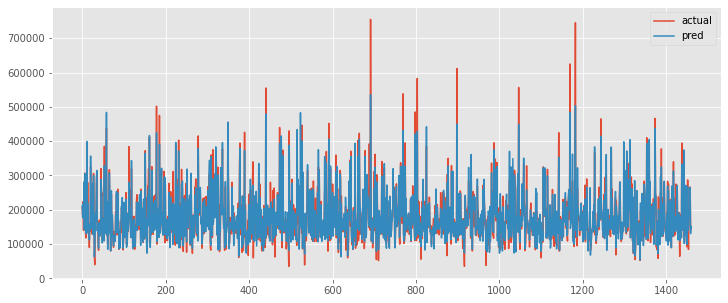

In [ ]:
actual_pred_df = pd.DataFrame({
    "actual":train_Y,
    "pred": oof
})
actual_pred_df.plot(figsize=(12,5))

実際の値が大きくなる時に、予測できていない。

各変数の重要度を確認する

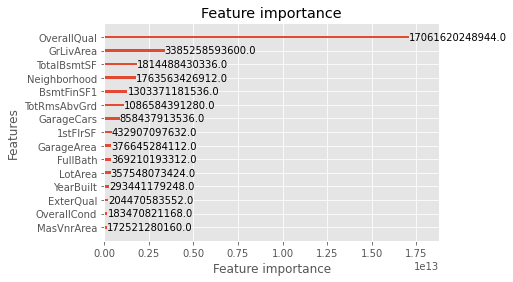

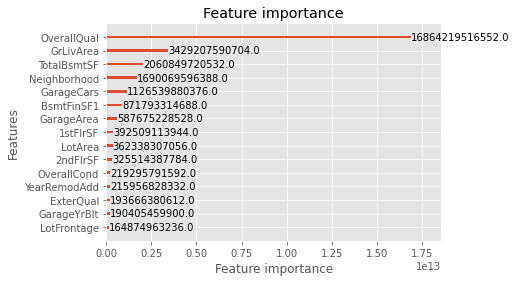

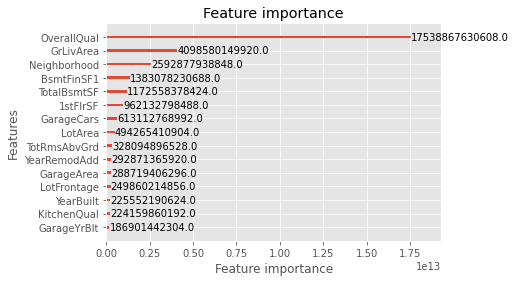

In [ ]:
for model in models:
  lgb.plot_importance(model, importance_type="gain", max_num_features=15)